In [1]:
#%%
# Standard library imports
from argparse import ArgumentParser
import os, sys
THIS_DIR = os.path.abspath('')
PARENT_DIR = os.path.dirname(os.path.abspath(''))
sys.path.append(PARENT_DIR)

# Third party imports
import torch
from torch.nn import functional as F
from torch.utils.data import DataLoader
import pytorch_lightning as pl
from pytorch_lightning import Trainer, seed_everything
from pytorch_lightning.callbacks import ModelCheckpoint
from torchdiffeq import odeint
from torchvision import utils
import matplotlib.pyplot as plt
import numpy as np

# local application imports
from lag_caVAE.lag import Lag_Net
from lag_caVAE.nn_models import MLP_Encoder, MLP, MLP_Decoder, PSD
from hyperspherical_vae.distributions import VonMisesFisher
from hyperspherical_vae.distributions import HypersphericalUniform
from utils import arrange_data, from_pickle, my_collate, ImageDataset
from examples.pend_lag_cavae_trainer import Model

seed_everything(0)
%matplotlib inline
DPI = 600

## Load Model

In [2]:
checkpoint_path = os.path.join(PARENT_DIR, 
                               'checkpoints', 
                               'pend-lag-cavae-T_p=4-epoch=701.ckpt')
model = Model.load_from_checkpoint(checkpoint_path)

## Prepare data

In [3]:
data_path=os.path.join(PARENT_DIR, 'datasets', 'pendulum-gym-image-dataset-test.pkl')
test_dataset = ImageDataset(data_path, 19, ctrl=False)

test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False, collate_fn=my_collate)

In [4]:
test_batch = next(iter(test_dataloader))
X, u = test_batch

In [5]:
model.t_eval = torch.from_numpy(test_dataset.t_eval)
model.hparams.solver = 'rk4'
model(X, u)

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "


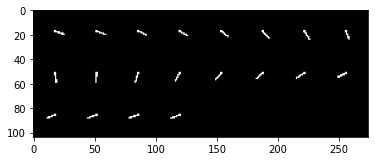

In [6]:
# data trajectory
b_ind = 0
grid = utils.make_grid(X[:, b_ind].view(-1, 1, 32, 32))
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


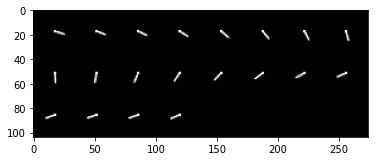

In [7]:
# prediction trajectory
grid = utils.make_grid(model.Xrec[:, b_ind].view(-1, 1, 32, 32))
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

## Plot learned potential energy

In [8]:
q = np.linspace(0, 2*np.pi, 41)
cos_q = np.cos(q[:-1])
sin_q = np.sin(q[:-1])
cos_q_sin_q = np.stack((cos_q, sin_q), axis=1)
cos_q_sin_q = torch.tensor(cos_q_sin_q, dtype=torch.float32)

Text(0, 0.5, '$V(\\phi)$')

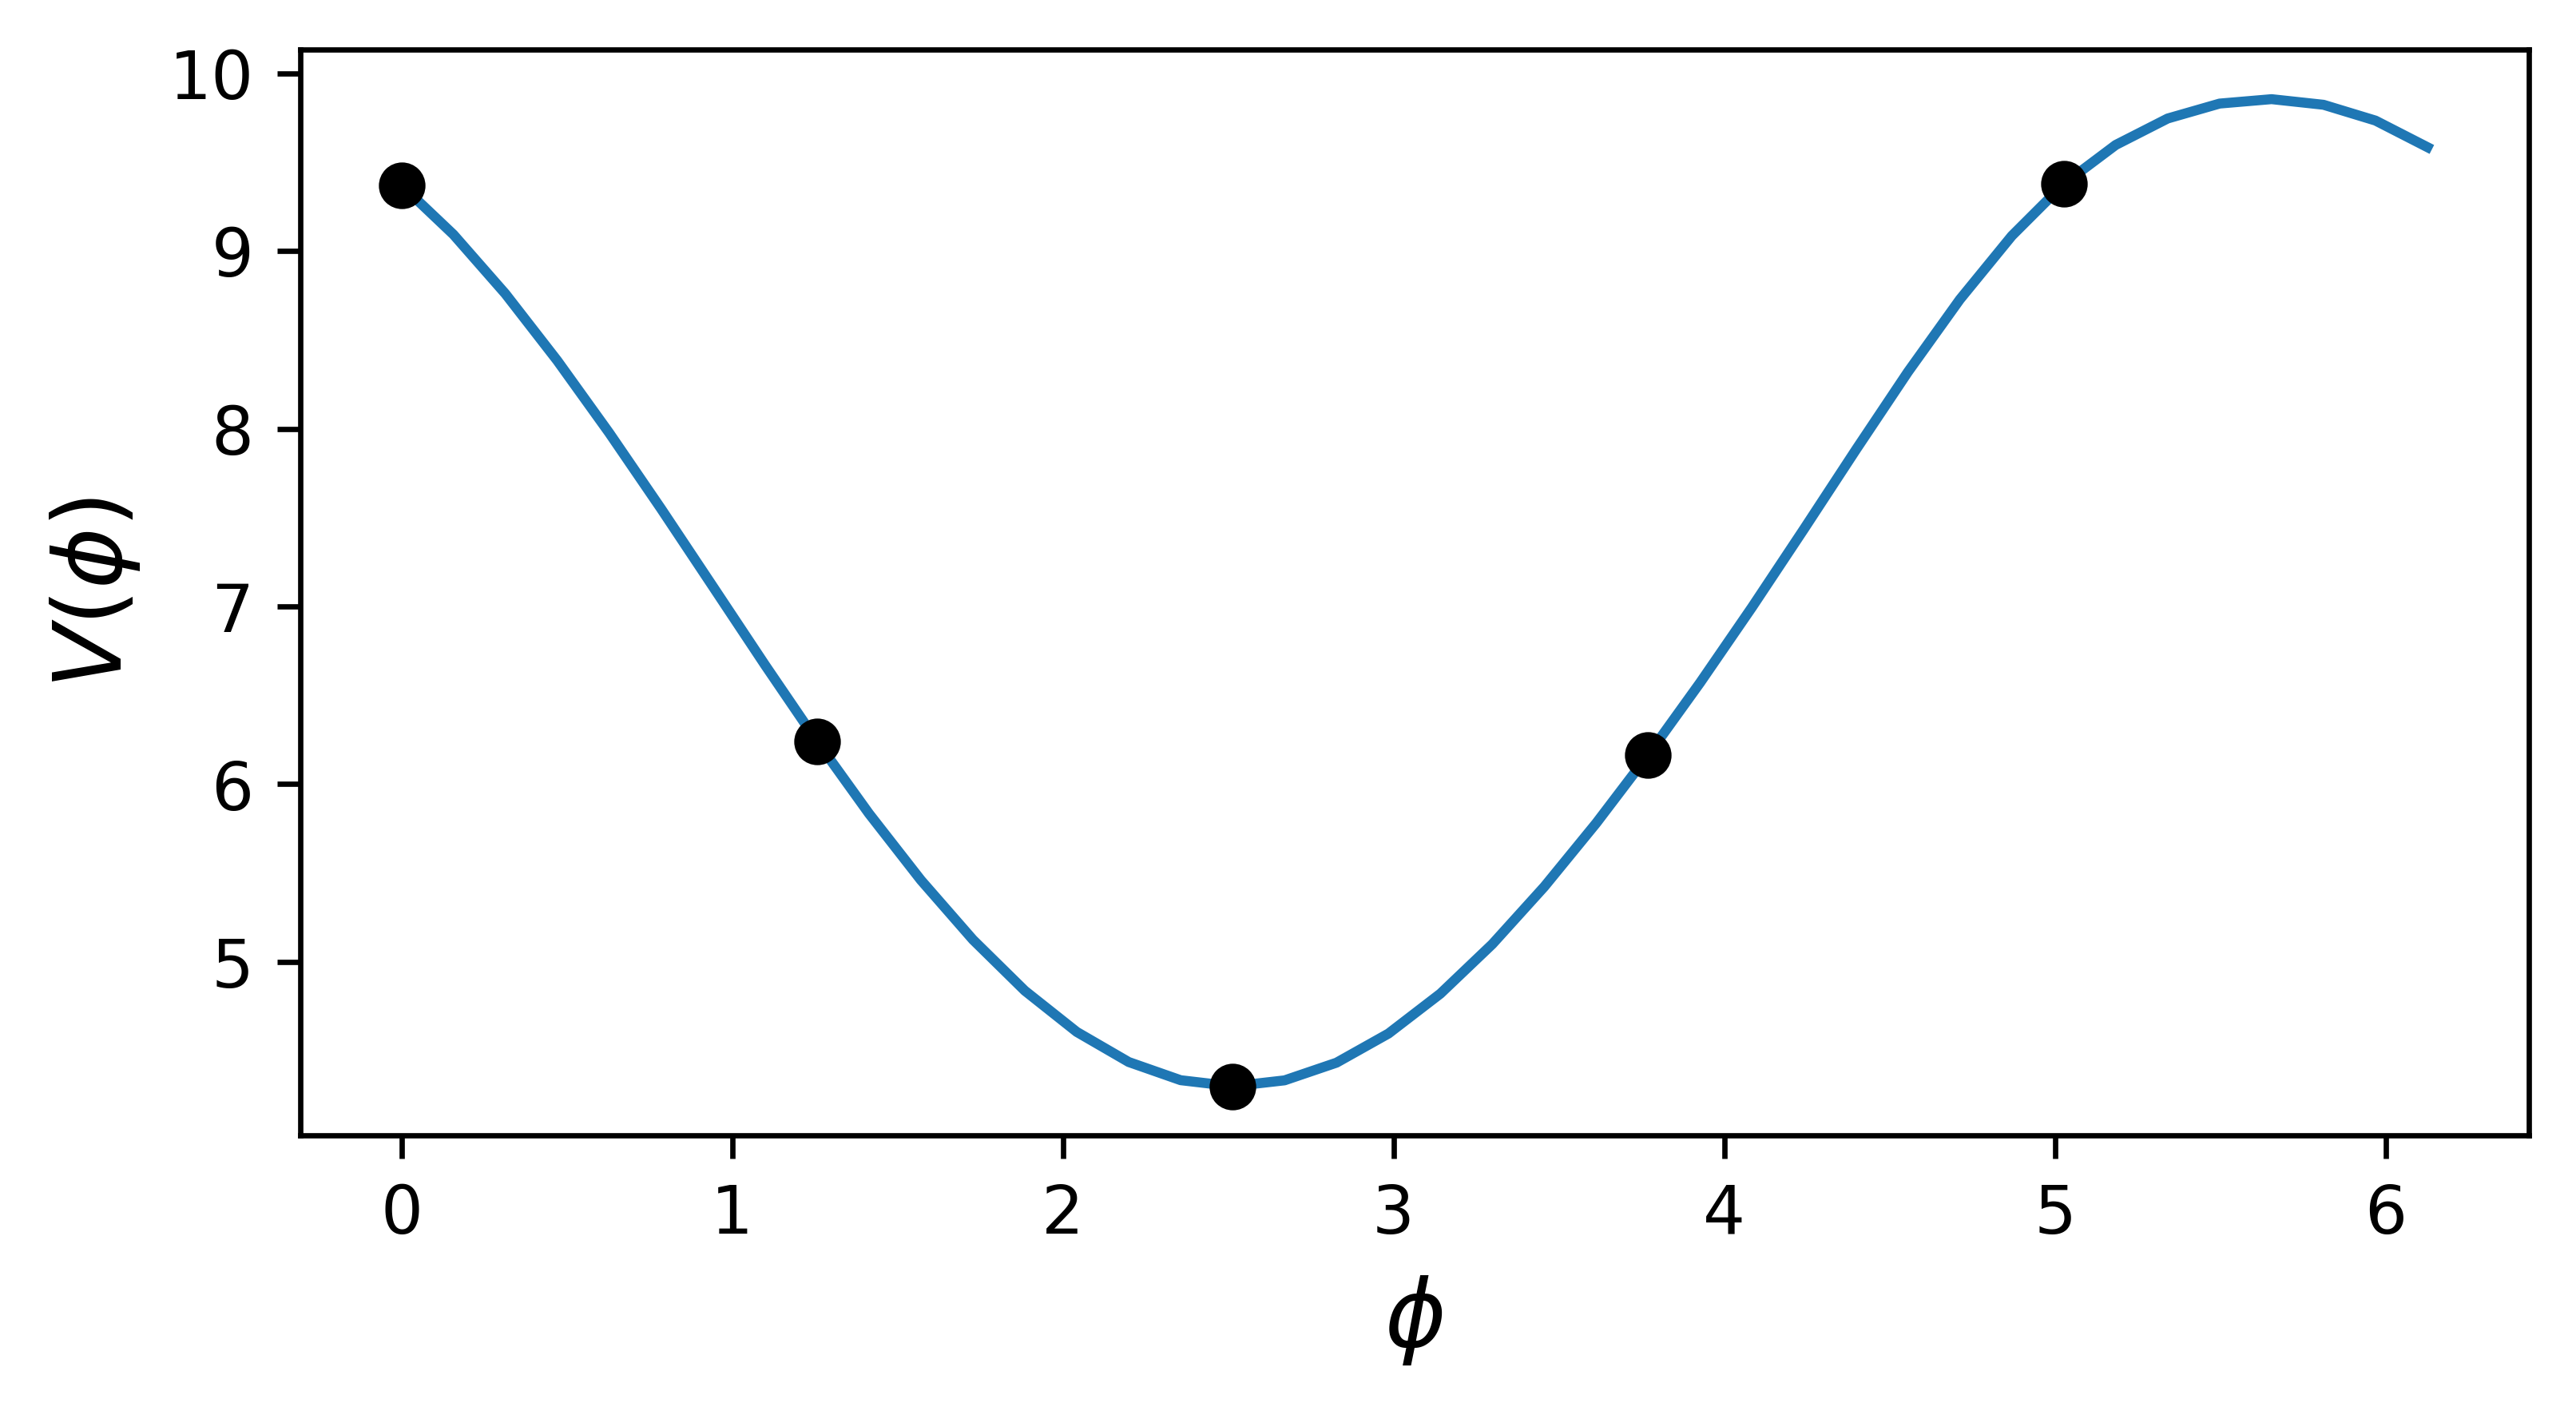

In [9]:
V_q = model.ode.V_net(cos_q_sin_q).detach().cpu().numpy()
fig = plt.figure(figsize=[6, 3], dpi=DPI)
markers_on = [0, 8, 16, 24, 32]
plt.plot(q[:-1], V_q, marker = 'o', markevery=markers_on, markerfacecolor=(0,0,0,1), markeredgecolor=(0,0,0,1))
plt.xlabel(r"$\phi$", fontsize=14)
plt.ylabel(r"$V(\phi)$", fontsize=14)
# plt.tight_layout()
# fig.savefig(os.path.join(PARENT_DIR, 'figures', 'pend_potential_energy'), bbox_inches='tight')

## Plot 5 reconstruction images corresponding to the black dots

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3447: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/torch/nn/functional.py:3384: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  warnings.warn("Default grid_sample and affine_grid behavior has changed "
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


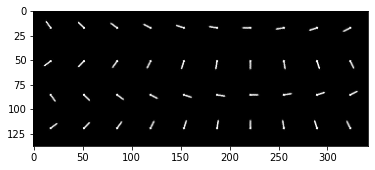

In [10]:
ones = torch.ones_like(cos_q_sin_q[:, 0:1])
content = model.obs_net(ones)

theta = model.get_theta_inv(cos_q_sin_q[:, 0], cos_q_sin_q[:, 1], 0, 0, bs=cos_q_sin_q.shape[0])
grid = F.affine_grid(theta, torch.Size((40, 1, 32, 32)))
Xrec = F.grid_sample(content.view(40, 1, 32, 32), grid)

fig = plt.figure()
grid = utils.make_grid(Xrec.view(40, 1, 32, 32), nrow=10)
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


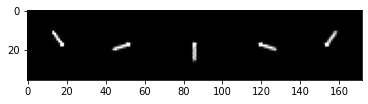

In [11]:
# for i in [0, 8, 16, 24, 32]:
#     fig = plt.figure()
#     plt.imshow(Xrec[i][0].detach().cpu().numpy(), cmap='gray')
#     plt.axis('off')
#     fig.savefig(os.path.join(PARENT_DIR, 'figures', f'pend_recon_{i}.png'), bbox_inches='tight')
grid = utils.make_grid(Xrec[0:40:8])
plt.imshow(grid.permute(1,2,0).detach().cpu().numpy())

# Control

In [12]:
import gym, myenv
import numpy as np
from skimage import color
from gym import wrappers
env = gym.make('MyPendulum-v0')

# prepare model instance
model.hparams.solver = 'rk4'
model.bs = 1
model.d = 32

# get a goal image
q_star = 0.0
env.reset()
env.state = np.array([q_star, 0.0], dtype=np.float32)
goal_frame = env.render(mode='rgb_array')
goal_frame = color.rgb2gray(goal_frame)
goal_frame = torch.tensor(goal_frame, dtype=torch.float32)
env.close()

# given a goal image, design controller
# first encode the goal image to goal coordinates
_, _, goal_q_n = model.encode(goal_frame.view(1, 32*32))

/home/desmond/.pyenv/versions/embed/lib/python3.7/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [13]:
goal_q_n

tensor([[ 0.8009, -0.5989]], grad_fn=<DivBackward0>)

In [14]:
q0 = 3.14

env.reset()
env.state = np.array([q0, 0.0], dtype=np.float32)
frame = color.rgb2gray(env.render(mode='rgb_array'))
frames = [frame]

frame = torch.tensor(frame, dtype=torch.float32)

for i in range(100):
    _, _, q_n = model.encode(frame.view(1, 32*32))
    
    if i==0:
        prev_q_n = q_n
        
    q_dot = model.angle_vel_est(prev_q_n, q_n, 0.05)

    V_q = model.ode.V_net(q_n)
    dV = torch.autograd.grad(V_q, q_n)[0]
    dV_dcos_q, dV_dsin_q = dV.split([1, 1], dim=1)
    dV_dq = - dV_dcos_q * q_n[:, 1] + dV_dsin_q * q_n[:, 0]
    g_q = model.ode.g_net(q_n)

#     energy_shaping = torch.zeros(2, 1, dtype=torch.float32)
#     energy_shaping[0][0] = dV_dr[0][0] - 3* (r_cos_phi_sin_phi[0][0] - 0.0)
#     energy_shaping[1][0] = 2 * dV_dphi[0][0]

    energy_shaping = dV_dq - 6 * (q_n[0, 1] * goal_q_n[0, 0] - q_n[0, 0] * goal_q_n[0, 1])
    damping_injection = - 1 * q_dot.T

    u = 1/g_q * (energy_shaping + damping_injection)

    u = u.detach().cpu().numpy()
    env.step(u)

    frame = color.rgb2gray(env.render(mode='rgb_array'))
    frames.append(frame)
    frame = torch.tensor(frame, dtype=torch.float32)

    prev_q_n = q_n

env.close()

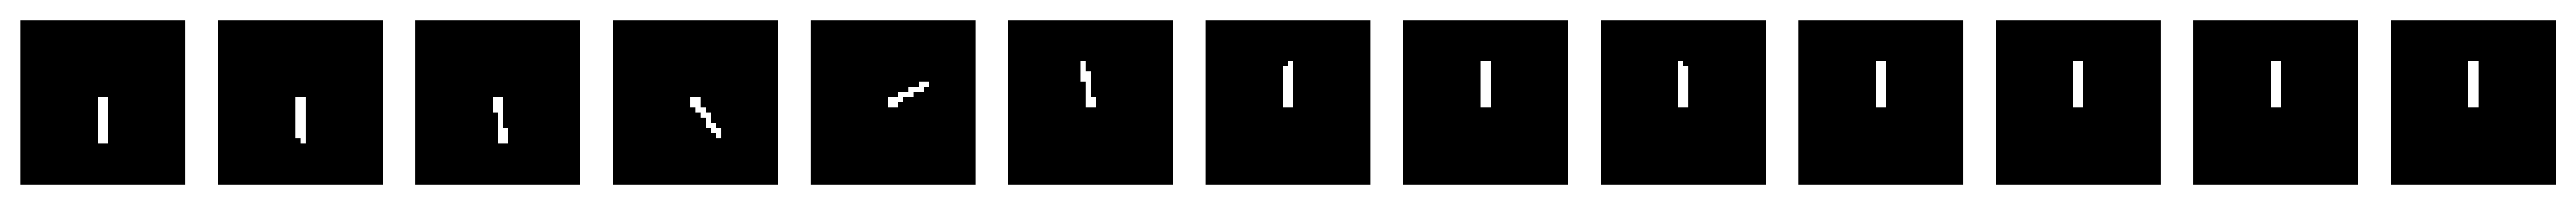

In [15]:
fig = plt.figure(figsize=(16, 4), dpi=DPI)
for i in range(13):
    plt.subplot(1, 13, i+1)
    plt.imshow(frames[i*8], cmap='gray')
    plt.axis('off')
    
# fig.savefig(os.path.join(PARENT_DIR, 'figures', 'pend-ctrl.png'), bbox_inches='tight')

In [16]:
# import imageio
# imageio.mimsave(os.path.join(PARENT_DIR, 'figures', 'pend-ctrl.gif'), frames, duration=0.05)

control animation ![control sequence](../figures/pend-ctrl.gif)

In [17]:
model.hparams

"T_pred":                         4
"accumulate_grad_batches":        1
"amp_level":                      O2
"auto_lr_find":                   False
"auto_scale_batch_size":          False
"auto_select_gpus":               False
"batch_size":                     512
"benchmark":                      False
"check_val_every_n_epoch":        1
"checkpoint_callback":            True
"default_root_dir":               None
"deterministic":                  False
"distributed_backend":            None
"early_stop_callback":            False
"fast_dev_run":                   False
"gradient_clip_val":              0
"learning_rate":                  0.001
"limit_test_batches":             1.0
"limit_train_batches":            1.0
"limit_val_batches":              1.0
"log_gpu_memory":                 None
"log_save_interval":              100
"logger":                         True
"max_epochs":                     1000
"max_steps":                      None
"min_epochs":                     1
